# Question 3: Business analytics skills test

The objective of these tests is to simulate hard skills you’re likely to use on a day to day basis.<br>
You’re required to submit 2 of the 3 questions. However, it’s a big plus if you submit all 3 questions.<br>
Please feel free to use any tool you’re comfortable with(such as Python, R, excel,Tableau).

### Set up Data

I put the raw data into my test database (free PostGreSQL on Heroku)<br>

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge

from py_topping.data_connection.database import da_tran_SQL # My PyPi library


with open('setting.txt','rb') as file : ## User and Password
    setting = json.load(file)
    setting = setting['POSTGRESQL']
    
plsql = da_tran_SQL(sql_type = setting['type'] , host_name = setting['host'], database_name = setting['database'],
                   user = setting['user'], password = setting['password'])

df_p = plsql.read('WN_Predictive')
df_v = plsql.read('WN_Visualize')

Connection OK


## 3.1 Predictive model
The company pays many food influencers(KOL) on facebook to promote Lineman.<br>
KOL does result in an increase of daily active users. <br>
As you want to optimize spending on KOL, you want to retain only top3 influencers in the next month.<br>
Based on the data below, please conduct an analysis and decide which 3 influencers we should use.

## Visualize Data

In [2]:
df_p = df_p.set_index('week')
df_p.T

week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
order,30000,37000,40800,31600,24900,30800,8000,16900,16800,31500,21000,21300,2500,25900,17700
A,1,3,3,1,2,1,1,3,4,2,2,0,0,0,0
B,0,0,3,2,1,1,1,3,3,2,0,1,2,2,1
C,5,6,5,5,4,5,0,0,0,4,4,5,0,4,3
D,2,2,0,0,3,2,2,3,1,1,0,3,2,2,1
E,4,4,3,1,1,2,4,5,2,2,1,4,3,3,2


In [3]:
des_df_p = df_p.describe()
des_df_p

,order,A,B,C,D,E
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,23780.000000,1.533333,1.466667,3.333333,1.600000,2.733333
std,10445.997183,1.302013,1.060099,2.193063,1.055597,1.279881
min,2500.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,17300.000000,0.500000,1.000000,1.500000,1.000000,2.000000
50%,24900.000000,1.000000,1.000000,4.000000,2.000000,3.000000
75%,31150.000000,2.500000,2.000000,5.000000,2.000000,4.000000
max,40800.000000,4.000000,3.000000,6.000000,3.000000,5.000000


## Normalize Data

To make it easier to see the relation, we need to normalize

In [4]:
for i in df_p.columns :
    df_p[i] = (df_p[i] - des_df_p.loc['mean',i])/des_df_p.loc['std',i]

df_p.head()

,order,A,B,C,D,E
week,,,,,,
1,0.595443,-0.409622,-1.383519,0.759972,0.378932,0.989675
2,1.265557,1.126461,-1.383519,1.215956,0.378932,0.989675
3,1.629332,1.126461,1.446406,0.759972,-1.515729,0.208353
4,0.748612,-0.409622,0.503098,0.759972,-1.515729,-1.354293
5,0.107218,0.358419,-0.440211,0.303989,1.326263,-1.354293


# See the trend of data

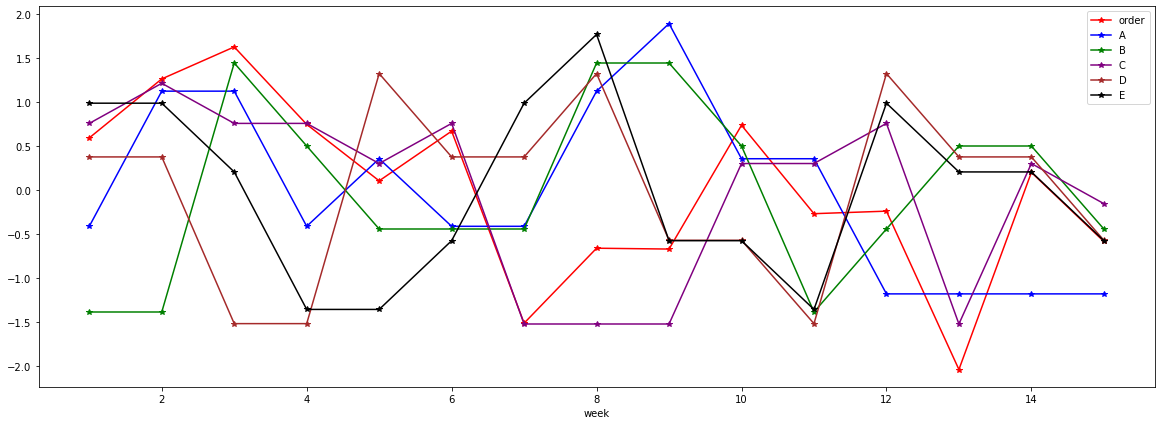

In [5]:
df_p.plot(kind = 'line',marker = '*',figsize = (20,7),color = ['red','blue','green','purple','brown','black'])
plt.show()

From Data Visualization, <br>
 - I could see clearly that purple (C) have some relative with red (order) <br>
 - And brown (D) may not so relate with red (order).

***

## From Visualization, I've 2 additional hypothesises

1. Effect maybe be lagging
2. Combination of 2 influencer

## So, I plan to make a model from 4 dataset
1. Original Dataset
2. Lagging Dataset
3. Polynomial Dataset
4. No.2 + No.3

## Prepare DataSet

In [6]:
#Create 2
def lagging(df_in) :
    for i in ['A','B','C','D','E'] :
        for j in [1,2] :
            df_in[i+'_s' + str(j)] = df_in[i].shift(j)
    df_in = df_in.dropna()
    return df_in

df1 = df_p.copy()
df1 = lagging(df1)
print(df1.shape)

#Create 3
def poly_df(df_in) :
    buf = df_in.reset_index()[['week','order']]
    poly = PolynomialFeatures(interaction_only=True,include_bias=False)
    x1 = df_in.drop(['order'],axis = 1)
    x1 = pd.DataFrame(poly.fit_transform(x1), columns = poly.get_feature_names(x1.columns))
    return pd.concat([buf.reset_index(drop = True), x1], axis=1).set_index('week')

df2 = df_p.copy()
df2 = poly_df(df2)
print(df2.shape)

#Create 4
df3 = df1.copy()
df3 = poly_df(df3)
print(df3.shape)

(13, 16)
(15, 16)
(13, 121)


## Build Training Pipeline

The pipeline will include 
 - plot top 10 correlation to order
 - divide data into train set and test set (Since it time series, I will leave last 4 weeks for test
 - use Ridge Regression to fit the model, with 7 alpha
 - use the best alpha from hold out sample for final fitting
 - pipeline will return model, coef and r2 result

In [7]:
def build_and_check(df_in,name_in):
    df_in.corr().drop('order').sort_values('order',ascending = False).head(10)['order'].plot(kind = 'bar',
                                                                                             title = 'relation',figsize = (10,5))
    plt.show()
    
    limit_train = 11

    x_train, y_train = df_in.loc[:limit_train,:].drop('order',axis = 1) , df_in.loc[:limit_train,:][['order']]
    x_test, y_test = df_in.loc[limit_train + 1:,:].drop('order',axis = 1) , df_in.loc[limit_train + 1:,:][['order']]

    print('train size :', len(x_train))
    print('test size :', len(x_test))

    stores = pd.DataFrame()
    param = [0 , 0.1 , 0.2 , 0.5 , 1 , 2 , 5]
    for i in  param:
        model_out = Ridge(alpha=i)
        model_out.fit(x_train,y_train)
        store = pd.DataFrame({'in' : [model_out.score(x_train,y_train)] , 'hold out' : [model_out.score(x_test, y_test)]})
        stores = stores.append(store)

    stores.index = param
    stores.plot(kind = 'line',marker = '*', figsize =(10,5), title = 'Check Fitting')
    plt.show()
    print(np.round(stores.T*100,2))

    select_alpha = stores.index[np.argmax(stores['hold out'])]
    print('\n===============================\nUse Alpha :',select_alpha)
    model_out = Ridge(alpha=select_alpha)
    model_out.fit(x_train,y_train)

    result = df_in.copy()
    result['pred'] = model_out.predict(df_in.drop(['order'], axis = 1))
    result[['order','pred']].plot(kind = 'line', figsize =(10,5), title = 'End Result')
    plt.show()
    score_out = pd.DataFrame({'in' : [model_out.score(x_train,y_train)], 'hold out' : [model_out.score(x_test, y_test)]})
    score_out.index = [name_in]
    print('in :',score_out['in'])
    print('hold out :',score_out['hold out'])
    coef_out = pd.DataFrame(index = x_train.columns, data = model_out.coef_[0]).sort_values(0,ascending = False).head(5).T
    coef_out.index = [name_in]
    print('==============\nCoef \n',coef_out)
    return model_out, coef_out, score_out

## Run All model and see result


 original 


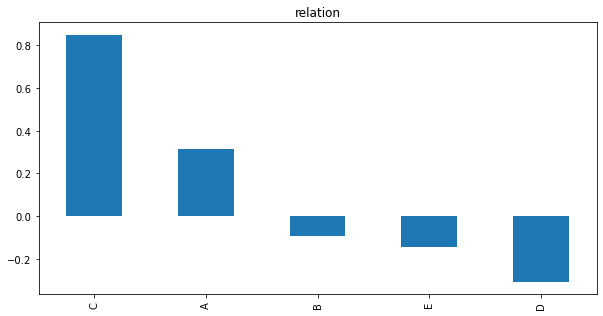

train size : 11
test size : 4


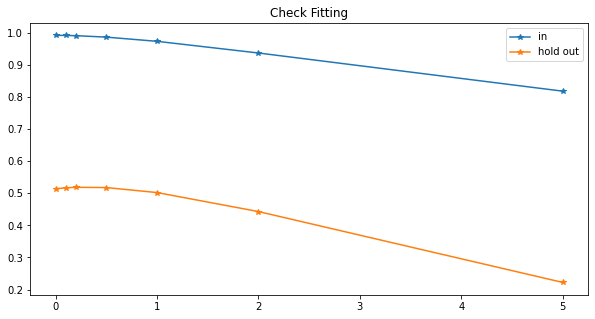

           0.0    0.1    0.2    0.5    1.0    2.0   5.0
in        99.2  99.17  99.10  98.65  97.34  93.70  81.8
hold out  51.4  51.68  51.85  51.77  50.21  44.29  22.2

Use Alpha : 0.2


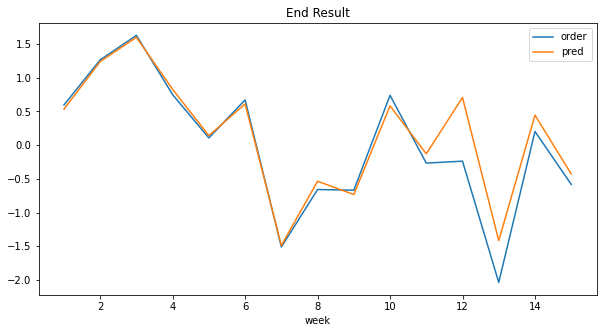

in : original    0.990988
Name: in, dtype: float64
hold out : original    0.51851
Name: hold out, dtype: float64
Coef 
                  C         B         A         E         D
original  1.020861  0.323559  0.156395  0.145623 -0.012576

 lagging 


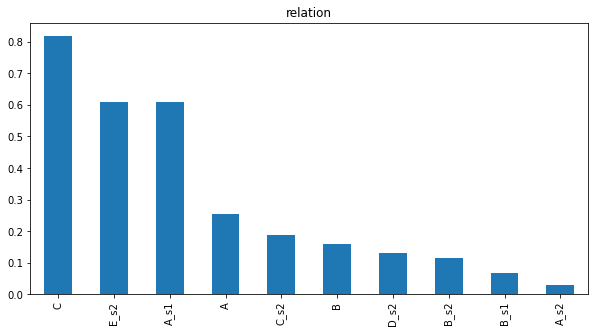

train size : 9
test size : 4


C:\Users\chanonkr\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.85491e-17): result may not be accurate.
  overwrite_a=False)


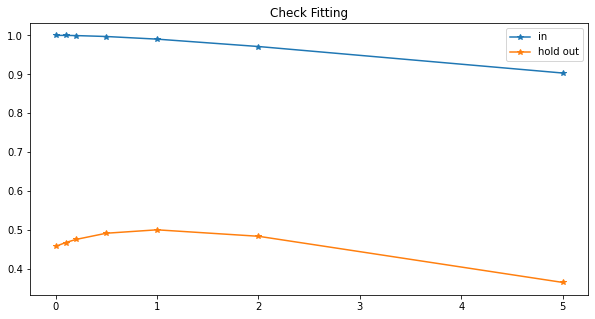

             0.0    0.1    0.2    0.5    1.0    2.0    5.0
in        100.00  99.99  99.95  99.71  99.03  97.13  90.33
hold out   45.84  46.81  47.61  49.21  50.08  48.43  36.58

Use Alpha : 1.0


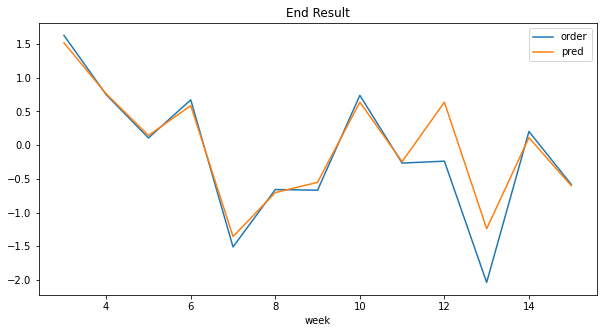

in : lagging    0.990308
Name: in, dtype: float64
hold out : lagging    0.500839
Name: hold out, dtype: float64
Coef 
                 C      A_s1      E_s2         B     C_s2
lagging  0.496351  0.253322  0.232611  0.177838  0.14946

 poly 


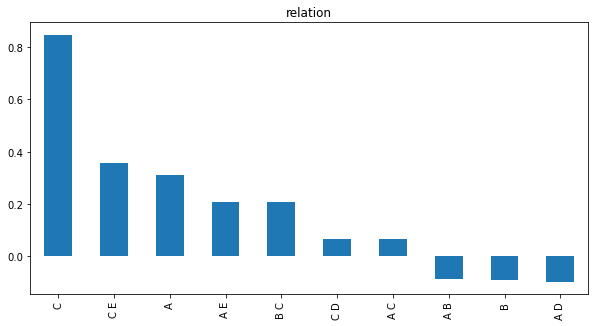

train size : 11
test size : 4


C:\Users\chanonkr\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


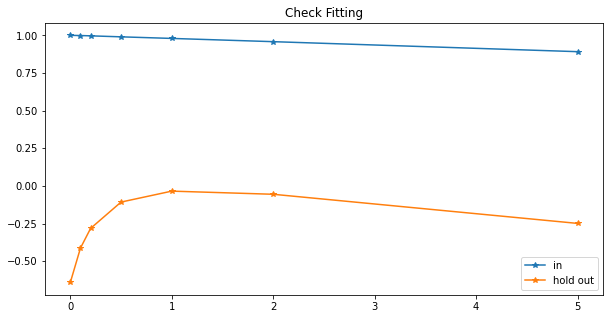

             0.0    0.1    0.2    0.5    1.0    2.0    5.0
in        100.00  99.88  99.68  99.02  97.96  95.81  89.16
hold out  -64.13 -41.30 -28.22 -10.74  -3.47  -5.56 -24.91

Use Alpha : 1.0


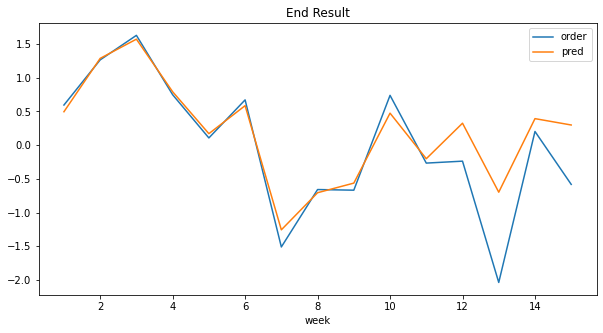

in : poly    0.979622
Name: in, dtype: float64
hold out : poly   -0.034719
Name: hold out, dtype: float64
Coef 
             C       A E       C E         B       A C
poly  0.63965  0.263238  0.235739  0.193428  0.052706

 lagging_poly 


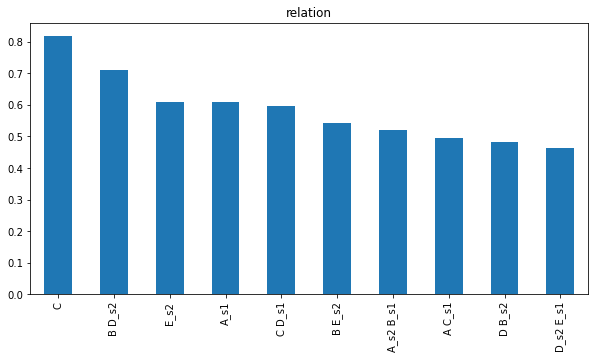

train size : 9
test size : 4


C:\Users\chanonkr\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.87256e-17): result may not be accurate.
  overwrite_a=False)


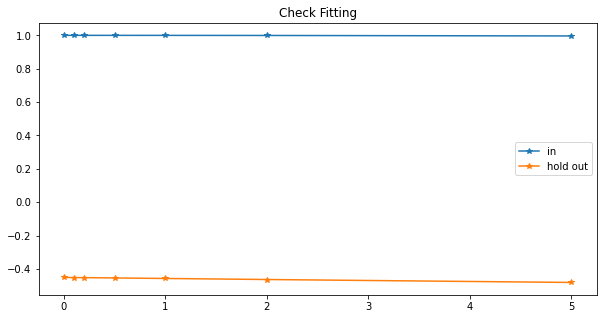

             0.0     0.1     0.2     0.5    1.0    2.0    5.0
in        100.00  100.00  100.00  100.00  99.98  99.94  99.64
hold out  -45.03  -45.09  -45.16  -45.35 -45.66 -46.28 -48.04

Use Alpha : 0.0


C:\Users\chanonkr\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.87256e-17): result may not be accurate.
  overwrite_a=False)


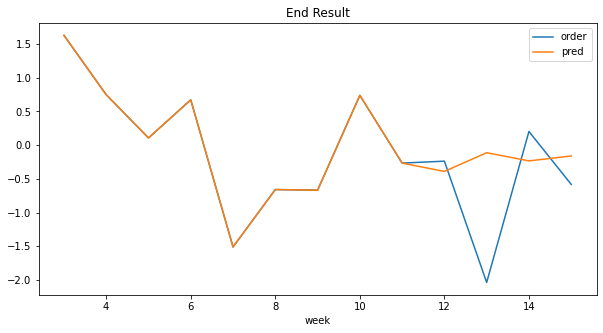

in : lagging_poly    1.0
Name: in, dtype: float64
hold out : lagging_poly   -0.450293
Name: hold out, dtype: float64
Coef 
               D_s2 E_s2         C    C D_s2      E_s2  D_s2 E_s1
lagging_poly   0.095345  0.075086  0.054773  0.049568   0.045813


In [8]:
coef_all = pd.DataFrame()
score_all = pd.DataFrame()

list_data = {'original' : df_p,'lagging' : df1, 'poly':df2,'lagging_poly':df3}

for i in list_data.keys() :
    print('\n==================================\n',i,'\n==================================')
    model, coef, score_r = build_and_check(list_data[i],i)
    coef_all = coef_all.append(coef)
    score_all = score_all.append(score_r)

## The result

In [9]:
score_all

,in,hold out
original,0.990988,0.518510
lagging,0.990308,0.500839
poly,0.979622,-0.034719
lagging_poly,1.000000,-0.450293


- original model is the best
- lagging model almost has the same accuracy as original model
- while polynomial and lagging + polynomial are overfitting

So, I'd should the original model

## Select the best 3 influencers


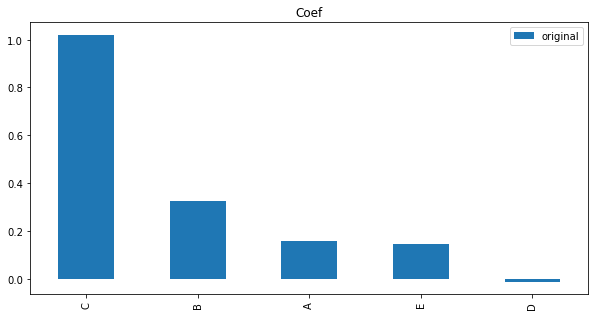

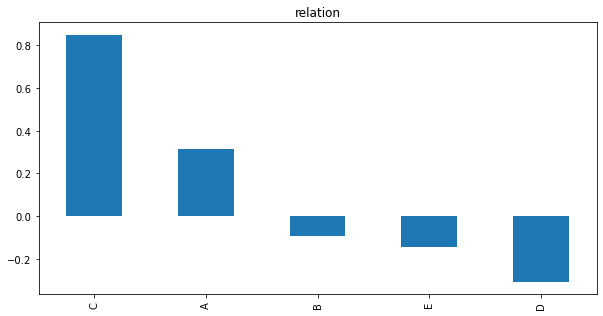

In [10]:
coef_all.T[['original']].head(5).sort_values('original',ascending = False).plot(kind = 'bar', figsize = (10,5))
plt.title('Coef')
plt.show()

df_p.corr().drop('order').sort_values('order',ascending = False)['order'].plot(kind = 'bar',
                                                                                             title = 'relation',figsize = (10,5))
plt.show()

## So, from Coefficient and Correlation
## The best 3 influencers, we should use would be C, B, A

***

## 3.2 Data visualization
You noticed that drivers don’t want to pick up food from restaurant A at Central World. <br>
Your hypothesis is that the average time per trip for picking up at restaurant A <br>
could be more than others so the driver accepts the job from other restaurants instead.<br>
Please build a data visualization to prove this hypothesis.

In [11]:
df_v = df_v.set_index('Restaurant')
df_v

,Drive_to_building,Parking_to_restaurant,Wait_for_food,Restaurant_to_parking,Drive_to_customer,Driver_acceptance_rate
Restaurant,,,,,,
A,3,10,3,9,2,0.65
B,2,7,5,6,4,0.90
C,6,7,6,7,3,0.91
D,5,5,10,5,3,0.98
E,5,2,8,3,2,0.92
F,6,2,3,3,5,0.94
G,2,7,4,5,4,0.90
H,7,4,2,5,4,0.91
I,6,4,5,4,2,0.89


## Filter Only Relavant Data

There're some data that have effect from driver's or customer's location.<br>
So, these data must be drop or they will lead to mis-communication

In [12]:
df_v1 = df_v.drop(['Drive_to_building','Drive_to_customer'],axis = 1)
df_v1

,Parking_to_restaurant,Wait_for_food,Restaurant_to_parking,Driver_acceptance_rate
Restaurant,,,,
A,10,3,9,0.65
B,7,5,6,0.90
C,7,6,7,0.91
D,5,10,5,0.98
E,2,8,3,0.92
F,2,3,3,0.94
G,7,4,5,0.90
H,4,2,5,0.91
I,4,5,4,0.89


## Pre-Visualization Relavant Data

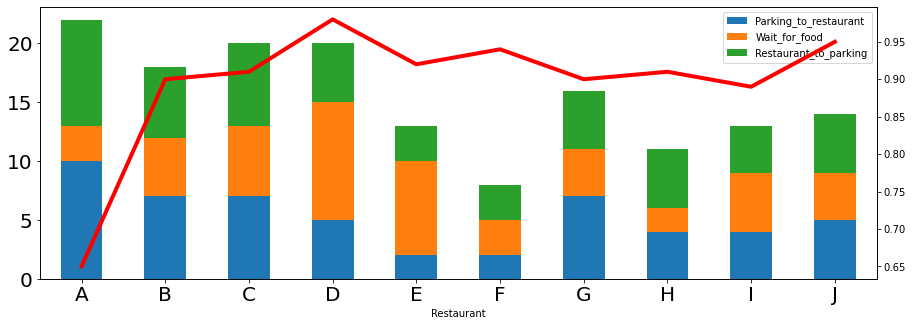

In [13]:
df_v1.drop(['Driver_acceptance_rate'],axis = 1).plot(kind = 'bar',stacked = True,figsize = (15,5), fontsize = 20)
df_v1['Driver_acceptance_rate'].plot(kind = 'line',linewidth=4 ,figsize = (15,5) , secondary_y=True,color = 'red')
plt.show()

From the Visualization we found restaurant A has the longest leadtime and lowest acceptance<br>
But why the 2nd longest leadtime like C has average level of acceptance

## So, categorize into the activities
 - Drive to building and Drive to customer : are driving
 - Parking_to_restaurant and Restaurant_to_parking : are walking
 - Wait_for_food : are waiting

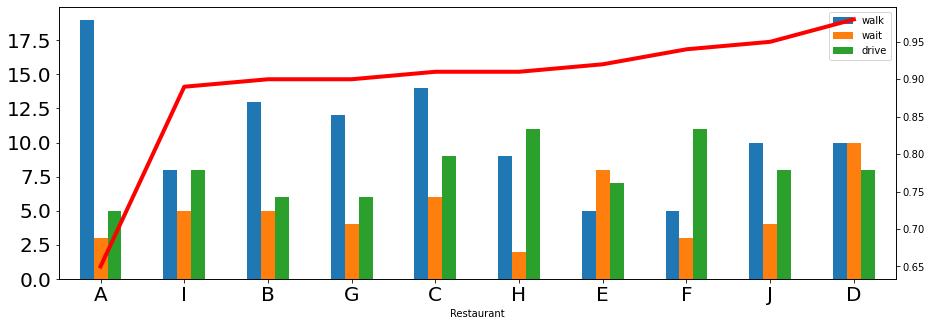

In [14]:
df_v2 = df_v.copy()
df_v2['walk'] = df_v2['Parking_to_restaurant'] + df_v2['Restaurant_to_parking']
df_v2['wait'] = df_v2['Wait_for_food']
df_v2['drive'] = df_v2['Drive_to_building'] + df_v2['Drive_to_customer']
df_v2 = df_v2.sort_values('Driver_acceptance_rate')
df_v2[['walk','wait','drive']].plot(kind = 'bar',figsize = (15,5), fontsize = 20)
df_v2['Driver_acceptance_rate'].plot(kind = 'line',linewidth=4,figsize = (15,5) , secondary_y=True,color = 'red')
plt.show()

## So, we found out that restaurant A's lowest acceptance 
## Because of the longest walking time and very low waiting time for rest

As shown in the bar chart below

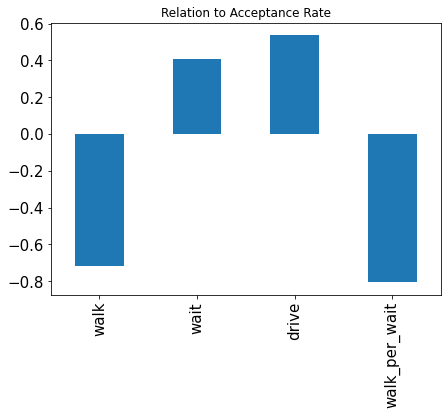

In [15]:
df_v3 = df_v2[['walk','wait','drive','Driver_acceptance_rate']]
df_v3['walk_per_wait'] = df_v3['walk']/df_v3['wait']

df_v3.corr()['Driver_acceptance_rate'].drop('Driver_acceptance_rate').plot(kind = 'bar',figsize = (7,5),fontsize = 15)
plt.title('Relation to Acceptance Rate')
plt.show()

## 3.3 Data query(SQL)
Please write anything you know about SQL based on your past experience<br>
(such as achievement, working experience, academic experience). (No more than 1 page)

## Testing with my favorite SQL Server

In [16]:
table_name = 'WN_Predictive'
plsql.read(table_name, condition_in = 'week = 1')

,week,order,A,B,C,D,E
0,1,30000,1,0,5,2,4


In [17]:
with open('setting.txt','rb') as file : ## User and Password
    set_mssql = json.load(file)
    set_mssql = set_mssql['MSSQL']
    
mssql = da_tran_SQL(sql_type = set_mssql['type'],
                host_name = set_mssql['host'],
                database_name = set_mssql['database'],
                user = set_mssql['user'],
                password = set_mssql['password'])

Connection OK


In [18]:
df_sql = plsql.read(table_name)
df_sql['Add'] = 1
mssql.dump_whole(df_sql , 'test_WN')
mssql.read('test_WN')

Start Filter Existing data from df at  2020-12-11 23:26:53.369068
Dump data to  test_WN  End  2020-12-11 23:26:53.611499


,week,order,A,B,C,D,E,Add
0,1,30000,1,0,5,2,4,1
1,2,37000,3,0,6,2,4,1
2,3,40800,3,3,5,0,3,1
3,4,31600,1,2,5,0,1,1
4,5,24900,2,1,4,3,1,1
5,6,30800,1,1,5,2,2,1
6,7,8000,1,1,0,2,4,1
7,8,16900,3,3,0,3,5,1
8,9,16800,4,3,0,1,2,1
9,10,31500,2,2,4,1,2,1


In [19]:
df_sql['Add'] = 2
mssql.dump_replace(df_sql[df_sql['week'] > 5], 'test_WN', list_key = ['week'] ,debug = True)
mssql.read('test_WN')

Start delete old data at 2020-12-11 23:26:53.681313
Delete Last ['week'] at 2020-12-11 23:26:53.762098
delete from test_WN where [week] in ('6', '7', '8', '9', '10', '11', '12', '13', '14', '15')
Dump data to  test_WN  End  2020-12-11 23:26:53.949768


,week,order,A,B,C,D,E,Add
0,1,30000,1,0,5,2,4,1
1,2,37000,3,0,6,2,4,1
2,3,40800,3,3,5,0,3,1
3,4,31600,1,2,5,0,1,1
4,5,24900,2,1,4,3,1,1
5,6,30800,1,1,5,2,2,2
6,7,8000,1,1,0,2,4,2
7,8,16900,3,3,0,3,5,2
8,9,16800,4,3,0,1,2,2
9,10,31500,2,2,4,1,2,2


In [20]:
mssql.engine.execute("""CREATE OR ALTER PROCEDURE TEST_WN_SP @PARAM1 VARCHAR(100)
                  AS
                  SELECT * FROM test_WN WHERE week = @PARAM1""")

In [21]:
mssql.read('TEST_WN_SP',SP = True, param = {'@PARAM1' : 13})

,week,order,A,B,C,D,E,Add
0,13,2500,0,2,0,2,3,2


In [22]:
mssql.engine.execute("""DROP PROCEDURE TEST_WN_SP""")
mssql.engine.execute("""DROP TABLE test_WN""")

In [23]:
try : mssql.read('test_WN')
except  Exception as e : print(e)

(pymssql.ProgrammingError) (208, b"Invalid object name 'test_WN'.DB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\n")
[SQL: SELECT * FROM [test_WN]]
(Background on this error at: http://sqlalche.me/e/f405)


In [24]:
try : mssql.read('TEST_WN_SP', SP =True, param = {'@PARAM1' : 13})
except  Exception as e : print(e)

(pymssql.ProgrammingError) (2812, b"Could not find stored procedure 'TEST_WN_SP'.DB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\n")
[SQL: EXEC TEST_WN_SP  @PARAM1 = 13]
(Background on this error at: http://sqlalche.me/e/f405)
